#### Libraries

In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random
from scipy.stats import mode

#### Helper Functions

In [2]:
# Workaround to print images inside the Jupyter Notebook (cv.imshow method seems to be incompatible with Jupyter)
def display_img(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [278]:
# Print images side to side for comparison inside the Jupyter Notebook
def display_img_comp(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 5))   
    
    for i, img in enumerate(images):
        axs[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    fig.tight_layout()
    plt.show()

In [4]:
# Enhance contrast using Constrast Limited Adaptive Histogram Equalization
def enhance_contrast_img(img, clipLimit=1.0, tileGridSize=(8,8)):
    # Convert the image to 8-bit unsigned single channel (Gray Scale is required for CLAHE)
    img_p = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_p = clahe.apply(img_p)

    return img_p
    
# Resize image
def resize_img(img, width, height):
    img_p = cv.resize(img, (width, height))
    return img_p

In [5]:
# The whole pre-processing pipeline for a single image
def preprocess_image(img, resize=True):
    img_p = enhance_contrast_img(img)   
    
    # Resize the image
    if(resize):
        img_p = resize_img(img, 500, 500)
          
    return img_p

### Read the Data

In [23]:
# Parameters
width = 2500
height = 2500

# Input & Output Paths
img_paths_src_dict = {
    'training': r'data\Bone Age Datasets\Bone Age Training Set\boneage-training-dataset\boneage-training-dataset'
    , 'validation_1': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-1\boneage-validation-dataset-1'
    , 'validation_2': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-2\boneage-validation-dataset-2'
    , 'test': r'data\Bone Age Datasets\Bone Age Test Set\Test Set Images'
}

img_paths_dest_dict = {
    'training': r'data\pre_processed\training'
    , 'validation_1': r'data\pre_processed\validation\validation_1'
    , 'validation_2': r'data\pre_processed\validation\validation_2'
    , 'test': r'data\pre_processed\test'
}

# Get the relative paths for all images per split of the data
img_rel_paths_dict = {}

for split in img_paths_src_dict:
    rel_paths_split = {}
    dir = img_paths_src_dict[split]
    file_names = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    relative_paths = [os.path.join(dir, f) for f in file_names]

    for path in relative_paths:
        img_id = int((path.split('\\')[-1]).split('.')[0])
        rel_paths_split[img_id] = path

    img_rel_paths_dict[split] = rel_paths_split

### TODO Convert this to a function

In [99]:
# Function that writes the outputs of the processed images to disk
# def pre_process_imgs(img_rel_paths_dict, dataset_name, function):

# For each split (Training, Test, Validation sets)
dataset_name = 'raw_resized_250px'

for split in img_rel_paths_dict.keys():
    # Get the source paths of images in the split, and the path of their destination
    img_paths_analysis = img_rel_paths_dict[split]  
    path_split_dest = img_paths_dest_dict[split]

    # Create a folder with the datasetname inside that path, if it doesn't exist yet
    path_dest = '{0}\{1}'.format(path_split_dest, dataset_name)
    path_exists = os.path.exists(path_dest)
    
    if not path_exists:
        # Create a new directory because it does not exist
        os.makedirs(path_dest)

    # For each image belonging to the split, process the image and write the result to the provided folder
    for img_key in img_paths_analysis.keys():
        path_p = '{0}\{1}.png'.format(path_dest, img_key)
        path_src = img_paths_analysis[img_key]
        img_src = cv.imread(path_src)

        # Function to apply to the image before writing
        img_p = resize_img(img_src, 250, 250)

        cv.imwrite(path_p, img_p)

        # print(path_p)

        # Clean the memory for that image, as it is no longer needed
        del img_src, img_p

### Sampling

In [31]:
# Define where the sampling is done
split_sampling = 'training'

# Take % amount of samples of images from the training set to analyze
random.seed(642)
perc_samples = 0.25
n_samples = int(round(perc_samples*len(img_rel_paths_dict[split_sampling]), 0))
img_paths_analysis = random.sample(list(img_rel_paths_dict[split_sampling].keys()), n_samples)

# Read the images, preprocess and put both the source and the pre-processed image into a dictionary 
images = {}
for img_key in img_paths_analysis:
    img_src = cv.imread(img_rel_paths_dict[split_sampling][img_key])
    img_p = preprocess_image(img_src, resize=False)
    images[img_key] = {'img_src': img_src, 'img_p': img_p}

### Exploratory Data Analysis

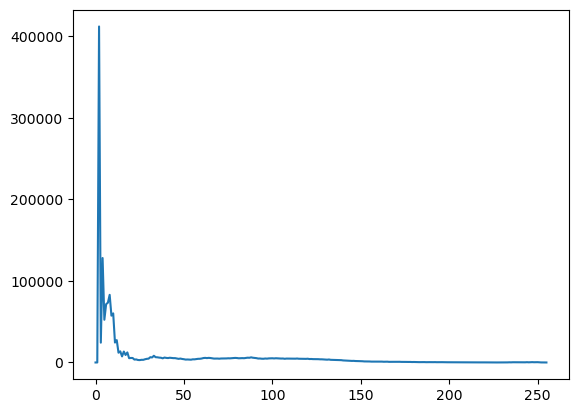

In [41]:
img_list = [images[img_key]['img_p'] for img_key in images ]

# The histogram for all images
hist = cv.calcHist(img_list, [0], None, [256], [0,256])
plt.plot(hist) 
plt.show()

### Analysis Per Image (Tests)

In [287]:
# Maps each key of the image to a sequential ID to make tests easier
seq_key = 19
rel_img_key = [*images.keys()]
img_key = rel_img_key[seq_key]

img_comp = images[img_key]
img = np.copy(img_comp['img_p'])

## Thresholding
# tc_s, img_thr = cv.threshold(img, 130, 255, cv.THRESH_BINARY) # Simple Thresholding
tc_o, img_thr_o = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) # Binary Thresholding through the Otsu method
img_thr_am = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2) # Adaptive Thresholding Mean C
img_thr_g = (img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)  # Adaptive Thresholding Gaussian C

## Gaussian Blur
blur_amount = (137, 137)
blur_sd = 5

# Gaussian Blur applied to each thresholded image to smooth it
img_blur_o = cv.GaussianBlur(img_thr_o, blur_amount, blur_sd)
img_blur_am = cv.GaussianBlur(img_thr_am, blur_amount, blur_sd)

## Contouring
# Then we find the contours
# contours, hierarchy = cv.findContours(img_blur, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
# cv.drawContours(img, contours, -1, (0, 137, 0), 5)
# cv.drawContours(img, contours[hierarchy[0][0][2]], -1, (0,255,0), 5)

Image Analyzed: 5737
Sequential ID: 19


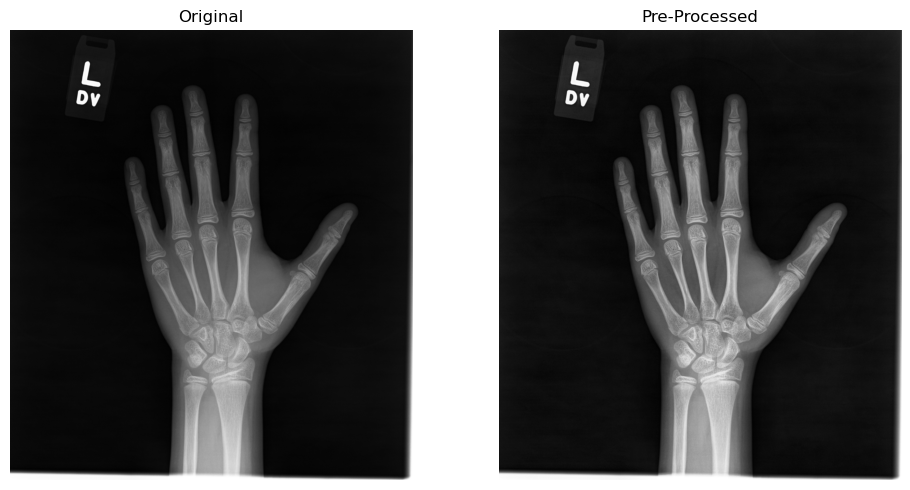

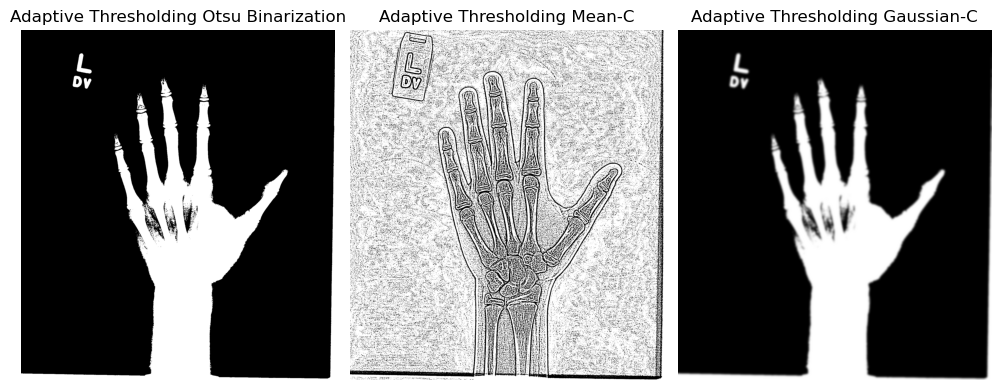

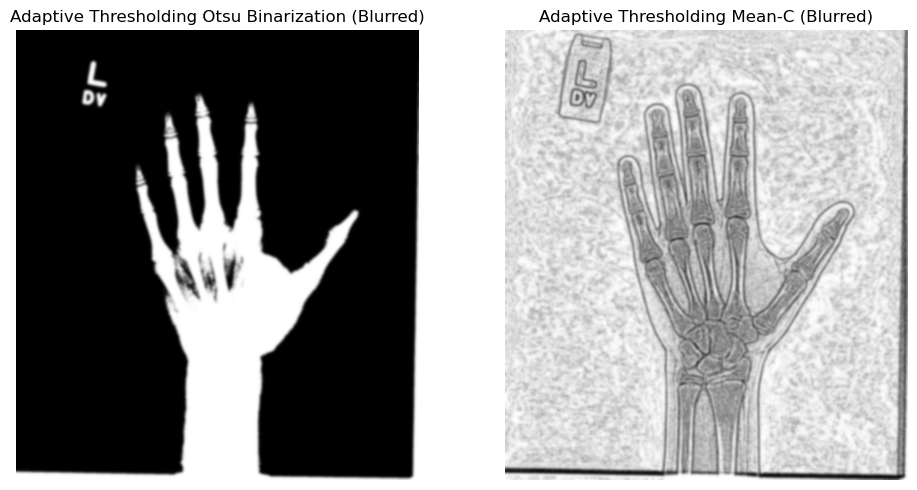

In [288]:
print('Image Analyzed: {0}'.format(img_key))
print('Sequential ID: {0}'.format(seq_key))

# Original vs. Processed
imgs_comp = [img_comp['img_src'], img_comp['img_p']]
labels = ['Original', 'Pre-Processed']
display_img_comp(imgs_comp, labels)

# Thresholding
imgs_comp = [img_thr_o, img_thr_am, img_blur_g]
labels = ['Adaptive Thresholding Otsu Binarization', 'Adaptive Thresholding Mean-C', 'Adaptive Thresholding Gaussian-C']
display_img_comp(imgs_comp, labels)

# Blurring
imgs_comp = [img_blur_o, img_blur_am]
labels = ['Adaptive Thresholding Otsu Binarization (Blurred)', 'Adaptive Thresholding Mean-C (Blurred)']
display_img_comp(imgs_comp, labels)

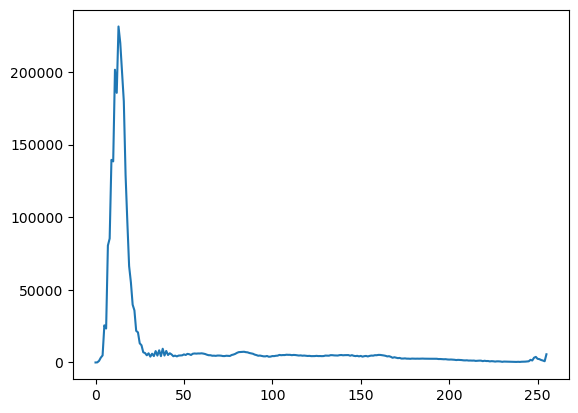

In [272]:
hist = cv.calcHist([img_comp['img_p']],[0],None,[256],[0,256])
plt.plot(hist)
plt.show()

Image Analyzed: 5737
Sequential ID: 19


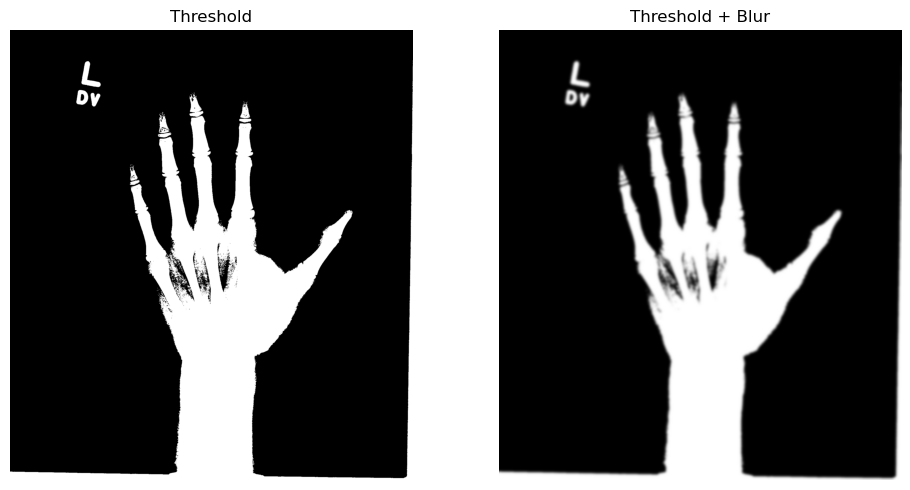

In [273]:
print('Image Analyzed: {0}'.format(img_key))
print('Sequential ID: {0}'.format(seq_key))
display_img_comp(img_thr, img_blur, 'Threshold', 'Threshold + Blur')

Image Analyzed: 5737
Sequential ID: 19


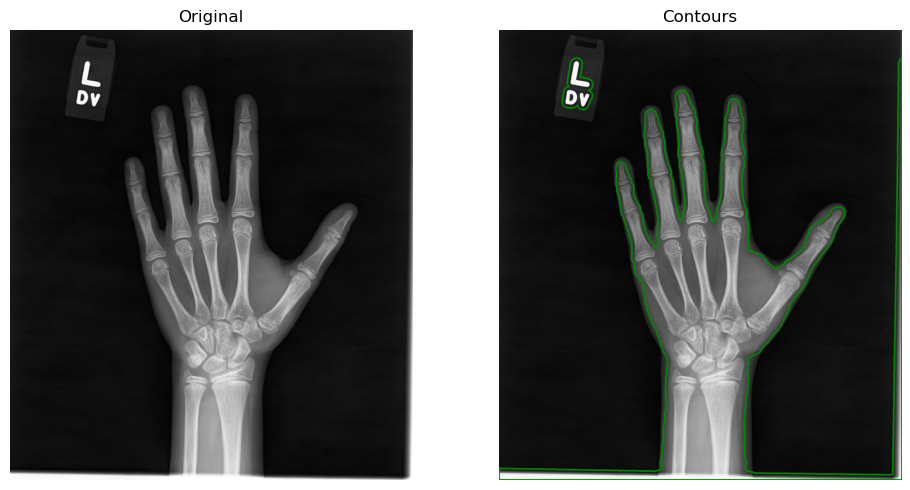

In [274]:
print('Image Analyzed: {0}'.format(img_key))
print('Sequential ID: {0}'.format(seq_key))
display_img_comp(img_comp['img_p'], img, 'Original', 'Contours')

In [ ]:
# Hola Mundo!

# Como fue el proyecto al final?
# [] Bien
# [] Mal
# [] Que buena pregunta